## Importing the necessary libraries

In [1]:
import json
import librosa
from sklearn.model_selection import train_test_split
import torch
import librosa.display
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## Audio Dataset Class

In [2]:
class AudioDataset(Dataset):
    """
    A custom dataset class for loading and processing audio files for sound event detection.

    Args:
        audio_files (list): A list of audio file names.
        annotations (dict): A dictionary with audio file names as keys and corresponding 
                             timestamp tuples (start_time, end_time) as values indicating 
                             the start and end of the event (e.g., cheering).
        sr (int, optional): The sampling rate for loading the audio files. Default is 22050.
        n_mels (int, optional): The number of Mel-frequency bins to use for the spectrogram. Default is 128.
        hop_length (int, optional): The number of samples between successive frames. Default is 2048.
        max_len (int, optional): The maximum length (in frames) to pad or truncate the spectrogram. Default is 1000.
        root_path (str, optional): The root directory where audio files are stored. Default is 'audios'.

    Attributes:
        audio_files (list): List of audio file names.
        annotations (dict): Annotations with timestamps for sound events.
        sr (int): Sampling rate for audio processing.
        n_mels (int): Number of Mel-frequency bins.
        hop_length (int): Hop length for Mel spectrogram computation.
        max_len (int): Maximum number of frames in the spectrogram.
        root_path (str): Path to the directory containing audio files.

    Methods:
        __len__(): Returns the number of audio files in the dataset.
        __getitem__(idx): Returns the Mel spectrogram and corresponding labels for a given index.
    """

    def __init__(self, audio_files: list, annotations: dict, sr: int = 22050, n_mels: int = 128,
                hop_length: int = 2048, max_len: int = 1000, root_path: str = 'audios'):
        """
        Initializes the dataset with the provided audio files, annotations, and other parameters.

        Args:
            audio_files (list): List of audio files to process.
            annotations (dict): Dictionary containing start and end timestamps for events in audio files.
            sr (int, optional): Sampling rate for loading the audio files. Default is 22050.
            n_mels (int, optional): Number of Mel-frequency bins for spectrogram. Default is 128.
            hop_length (int, optional): Hop length for spectrogram computation. Default is 2048.
            max_len (int, optional): Maximum number of frames to retain. Default is 1000.
            root_path (str, optional): Path to the folder where audio files are stored. Default is 'audios'.
        """
        self.audio_files = audio_files
        self.annotations = annotations
        self.sr = sr
        self.n_mels = n_mels
        self.hop_length = hop_length
        self.max_len = max_len
        self.root_path = root_path

    def __len__(self) -> int:
        """
        Returns the total number of audio files in the dataset.

        Returns:
            int: Number of audio files in the dataset.
        """
        return len(self.audio_files)

    def __getitem__(self, idx: int) -> tuple:
        """
        Retrieves the Mel spectrogram and event labels for a given index.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing:
                - torch.Tensor: The Mel spectrogram for the audio file (shape: [n_mels, time_steps]).
                - torch.Tensor: The labels corresponding to the spectrogram (shape: [time_steps]).
        """
        # Get the audio file name and path
        audio_file = self.audio_files[idx]
        audio_path = os.path.join(self.root_path, audio_file)

        # Load the audio file with the specified sampling rate
        y, _ = librosa.load(audio_path, sr=self.sr)

        # Compute the Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=self.sr, n_mels=self.n_mels, hop_length=self.hop_length)

        # Convert the Mel spectrogram to decibels
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # Normalize the Mel spectrogram
        mel_spec = (mel_spec - mel_spec.mean()) / mel_spec.std()

        # Create an empty label vector for the current audio file
        timestamps = self.annotations[audio_file]
        labels = np.zeros(mel_spec.shape[1])

        # Mark the event periods in the label vector
        for start, end in timestamps:
            start_idx = int(start * self.sr / self.hop_length)
            end_idx = int(end * self.sr / self.hop_length)
            labels[start_idx:end_idx] = 1

        # Ensure the spectrogram is within the maximum length
        if mel_spec.shape[1] > self.max_len:
            mel_spec = mel_spec[:, :self.max_len]
            labels = labels[:self.max_len]
        else:
            # Pad the spectrogram and labels if needed
            pad_width = self.max_len - mel_spec.shape[1]
            mel_spec = np.pad(mel_spec, ((0, 0), (0, pad_width)), mode='constant')
            labels = np.pad(labels, (0, pad_width), mode='constant')

        # Return the Mel spectrogram and the labels as tensors
        return torch.tensor(mel_spec, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)

## Model Class

In [3]:
import torch
import torch.nn as nn

class LSTMSoundClassifier(nn.Module):
    """
    LSTM-based sound classifier model for sound event detection (e.g., cheering detection).

    Args:
        input_size (int): The number of input features for each time step (e.g., number of Mel-frequency bins).
        hidden_size (int): The number of features in the hidden state of the LSTM.
        num_layers (int): The number of LSTM layers.
        output_size (int): The number of output classes (e.g., 1 for binary classification).

    Attributes:
        lstm (nn.LSTM): The LSTM layer for sequence processing.
        fc (nn.Linear): The fully connected layer that maps the LSTM output to the final classification score.
        sigmoid (nn.Sigmoid): The sigmoid activation function for binary classification.
    """

    def __init__(self, input_size: int, hidden_size: int, num_layers: int, output_size: int):
        """
        Initializes the LSTM-based sound classifier with the given parameters.

        Args:
            input_size (int): Number of input features (e.g., Mel-frequency bins).
            hidden_size (int): Number of hidden units in the LSTM.
            num_layers (int): Number of LSTM layers.
            output_size (int): Number of output units (e.g., 1 for binary classification).
        """
        super(LSTMSoundClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, time_steps, input_size).

        Returns:
            torch.Tensor: Output tensor after passing through the LSTM, fully connected layer, and sigmoid activation.
                        The output will have shape (batch_size, time_steps, output_size).
        """
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        out = self.fc(out)

        return self.sigmoid(out)


### Extracting the timestamps

In [4]:
def extract_timestamps(predictions, hop_length, sr, merge_threshold=2, duration_threshold=1):
    """
    Extract timestamps from a binary prediction array, merging adjacent detections 
    and filtering out short detections based on duration.

    Args:
        predictions (list): Binary array of predictions (1 or 0), where 1 indicates the presence of an event.
        hop_length (int): The hop length in samples (used to calculate time from frame indices).
        sr (int): The sample rate (samples per second), used to convert indices to time.
        merge_threshold (float, optional): The minimum time gap (in seconds) between adjacent detections to consider them separate. Default is 2 seconds.
        duration_threshold (float, optional): The minimum duration (in seconds) of an event to keep. Default is 1 second.

    Returns:
        list: A list of tuples representing the start and end times of detected events (in seconds).
    """
    timestamps = []
    start = None

    for i, pred in enumerate(predictions):
        if pred > 0.5 and start is None:
            start = i
        elif pred <= 0.5 and start is not None:
            end = i
            # Convert frame indices to time and store the detected timestamp
            timestamps.append((start * hop_length / sr, end * hop_length / sr))
            start = None

    # Handle the case where an event ends at the last frame
    if start is not None:
        timestamps.append((start * hop_length / sr, len(predictions) * hop_length / sr))
    
    merged_timestamps = []
    for ts in timestamps:
        if not merged_timestamps or ts[0] - merged_timestamps[-1][1] > merge_threshold:
            # No overlap, append as new event
            merged_timestamps.append(ts)
        else:
            # Merge adjacent events into one
            merged_timestamps[-1] = (merged_timestamps[-1][0], ts[1])
    
    # Filter out events that are too short based on the duration_threshold
    merged_timestamps = [ts for ts in merged_timestamps if ts[1] - ts[0] >= duration_threshold]
    
    return merged_timestamps


### Function for model training

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    """
    Train and validate the model for the specified number of epochs.

    Args:
        model (nn.Module): The neural network model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        criterion (nn.Module): The loss function used for training.
        optimizer (torch.optim.Optimizer): Optimizer for updating model weights.
        epochs (int, optional): Number of training epochs. Defaults to 10.

    Returns:
        None
    """
    model.train()

    for epoch in range(epochs):
        total_train_loss = 0
        train_correct_predictions = 0
        train_total_samples = 0

        for mel_spec, labels in train_loader:
            optimizer.zero_grad()

            outputs = model(mel_spec) 

            loss = criterion(outputs.squeeze(), labels.squeeze())
            loss.backward()
            optimizer.step() 

            total_train_loss += loss.item()

            predictions = (outputs.squeeze() > 0.5).float()
            train_correct_predictions += (predictions == labels).sum().item()
            train_total_samples += labels.numel()

        # Calculate average training loss and accuracy for this epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = train_correct_predictions / train_total_samples

        model.eval()

        total_val_loss = 0
        val_correct_predictions = 0
        val_total_samples = 0

        with torch.no_grad():
            for mel_spec, labels in val_loader:
                outputs = model(mel_spec)

                loss = criterion(outputs.squeeze(), labels.squeeze())
                total_val_loss += loss.item()

                predictions = (outputs.squeeze() > 0.5).float()
                val_correct_predictions += (predictions == labels).sum().item()
                val_total_samples += labels.numel()

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = val_correct_predictions / val_total_samples

        print(f"Epoch {epoch+1}/{epochs} -> "
            f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4%}, "
            f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4%}")


### Loading the dataset and running training code

In [6]:
# Hop Length: Number of samples between consecutive frames in the spectrogram
HOP_LENGTH = 1024
# Number of Mel frequency bands for Mel spectrogram
N_MELS = 64
# Sample rate of the audio (samples per second)
SAMPLE_RATE = 22050
# Hidden size of the LSTM layer (number of LSTM units)
HIDDEN_SIZE = 64
# Maximum length of the input sequence (number of frames)
MAX_LEN = 1000  # ~600 for (hop_length=2048, sample_rate=22k), 1000 for (hop_length=1024, sample_rate=22k)
# Training number of epochs
EPOCHS = 10
# Audios root directory path
DATASET_ROOT_DIRECTORY = 'audios'

In [7]:
# Load annotations from JSON file
with open("annotations.json", "r") as f:
    annotations = json.load(f)

# Extract the audio files from the annotations
audio_files = list(annotations.keys())

# Split the dataset into training and validation sets (80% training, 20% validation)
train_files, val_files = train_test_split(audio_files, test_size=0.2, random_state=42)

# Initialize the datasets
train_dataset = AudioDataset(
    audio_files=train_files, 
    annotations=annotations, 
    n_mels=N_MELS, 
    hop_length=HOP_LENGTH, 
    max_len=MAX_LEN,
    root_path=DATASET_ROOT_DIRECTORY
)

val_dataset = AudioDataset(
    audio_files=val_files, 
    annotations=annotations, 
    n_mels=N_MELS, 
    hop_length=HOP_LENGTH, 
    sr=SAMPLE_RATE, 
    max_len=MAX_LEN,
    root_path = DATASET_ROOT_DIRECTORY
)

# Create DataLoader instances for both training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Initialize the model, loss function, and optimizer
model = LSTMSoundClassifier(input_size=N_MELS, hidden_size=HIDDEN_SIZE, num_layers=2, output_size=1)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS)

Epoch 1/10 -> Train Loss: 0.6834, Train Accuracy: 66.5750%, Val Loss: 0.6679, Val Accuracy: 77.9833%
Epoch 2/10 -> Train Loss: 0.6378, Train Accuracy: 83.1292%, Val Loss: 0.6089, Val Accuracy: 85.2833%
Epoch 3/10 -> Train Loss: 0.5730, Train Accuracy: 83.1417%, Val Loss: 0.5245, Val Accuracy: 86.0167%
Epoch 4/10 -> Train Loss: 0.4880, Train Accuracy: 85.2750%, Val Loss: 0.4521, Val Accuracy: 84.8667%
Epoch 5/10 -> Train Loss: 0.4123, Train Accuracy: 86.6917%, Val Loss: 0.3642, Val Accuracy: 85.9333%
Epoch 6/10 -> Train Loss: 0.3512, Train Accuracy: 88.3500%, Val Loss: 0.3832, Val Accuracy: 83.4667%
Epoch 7/10 -> Train Loss: 0.3462, Train Accuracy: 87.9125%, Val Loss: 0.3252, Val Accuracy: 85.3000%
Epoch 8/10 -> Train Loss: 0.3275, Train Accuracy: 87.8250%, Val Loss: 0.3311, Val Accuracy: 83.8667%
Epoch 9/10 -> Train Loss: 0.3109, Train Accuracy: 88.1250%, Val Loss: 0.2972, Val Accuracy: 85.4833%
Epoch 10/10 -> Train Loss: 0.3001, Train Accuracy: 88.1500%, Val Loss: 0.3014, Val Accuracy

### Save the model

In [48]:
torch.save(model.state_dict(), 'll_model.pth')

## Evaluation Function for confusion matrix and classification report

In [8]:
def create_confusion_matrix_and_report(model, val_loader):
    """
    Evaluates the model using the validation data loader and computes the confusion matrix and classification report.
    
    Args:
        model (torch.nn.Module): The trained model.
        val_loader (DataLoader): DataLoader containing validation data.
    """
    model.eval()  # Set model to evaluation mode
    all_preds = []  # List to store all predictions
    all_labels = []  # List to store all true labels

    with torch.no_grad():  # Disable gradient computation during evaluation
        for mel_spec, labels in val_loader:

            outputs = model(mel_spec)
            predictions = (outputs.squeeze() > 0.5).float()
            
            all_preds.extend(predictions.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Calculate confusion matrix using true and predicted labels
    cm = confusion_matrix(all_labels, all_preds, labels=[1, 0])  # 1 = Cheering, 0 = No Cheering
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cheering", "No Cheering"])

    # Print classification report (precision, recall, f1-score, etc.)
    report = classification_report(all_labels, all_preds, target_names=["No Cheering", "Cheering"])
    print(report)

    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

### Visualizing the results

              precision    recall  f1-score   support

 No Cheering       0.86      0.89      0.87      3548
    Cheering       0.83      0.78      0.80      2452

    accuracy                           0.84      6000
   macro avg       0.84      0.84      0.84      6000
weighted avg       0.84      0.84      0.84      6000



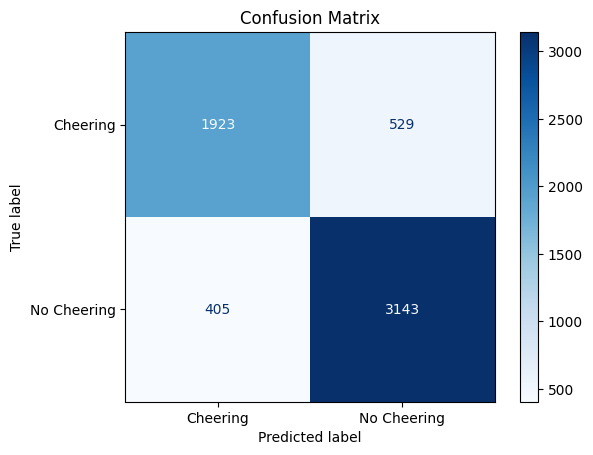

In [9]:
create_confusion_matrix_and_report(model, val_loader)

In [10]:

y, sample_rate = librosa.load('audios/audio25.mp3', sr=SAMPLE_RATE, mono=True)
mel_spec = librosa.feature.melspectrogram(y=y, sr=SAMPLE_RATE, n_mels=N_MELS, hop_length=HOP_LENGTH)
print(mel_spec.shape)
mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
mel_spec = (mel_spec - mel_spec.mean()) / mel_spec.std()
mel_spec = torch.tensor(mel_spec, dtype=torch.float32)
mel_spec = mel_spec.unsqueeze(0)
with torch.no_grad():
    predictions = model(mel_spec).squeeze().cpu().numpy()
timestamps = extract_timestamps(predictions, hop_length=HOP_LENGTH, sr=22050, merge_threshold=3)
print("TimeStamps:", timestamps)

(64, 969)
TimeStamps: [(5.154829931972789, 20.154920634920636), (27.910385487528345, 33.62249433106576), (38.26648526077098, 40.96)]
